In [1]:
%env CUDA_VISIBLE_DEVICES=2
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

import random
import cv2
from tqdm import tqdm,trange

from utils import *

env: CUDA_VISIBLE_DEVICES=2
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [3]:
model = VGGT()
_URL = "./model.pt"
model.load_state_dict(torch.load(_URL))
model.eval()
model = model.to(device)

/tmp/ipykernel_104709/2406001790.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(_URL))


In [22]:
idx = "2"

base_path = "/root/autodl-tmp/facescape"
img_path = os.path.join(base_path, "mv_image", idx)
depth_path = os.path.join(base_path, "depth", idx)
mask_path = os.path.join(base_path, "mask", idx)
params_path = os.path.join(base_path, "params", idx)

n_imgs = len(os.listdir(img_path))
def load_data(load_indices):
    depth_map = []
    extrinsic = []
    intrinsic = []
    images = []
    masks = []

    for load_index in load_indices:
        if False:
            img, depth, mask, extr, intr = data_cache[load_index]
        else:
            img = cv2.imread(os.path.join(img_path, f"{load_index}.png"))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (518, round(2592/1728*518)))
            # img = img[130:130+518, 0:518]
            depth = np.load(os.path.join(depth_path, f"{load_index}.npy"))
            # depth = cv2.resize(depth, (518, round(2592/1728*518)))
            # depth = depth[130:130+518, 0:518]
            mask = np.load(os.path.join(mask_path, f"{load_index}.npy"))
            # mask = cv2.resize(mask, (518, round(2592/1728*518)))
            # mask = mask[130:130+518, 0:518]
            params = np.load(os.path.join(params_path, f"{load_index}.npz"))
            extr = params["extr"]
            intr = params["intr"]
            # intr = intr * 518 / 1728
            # intr[1,2] = intr[1,2] - 130
            # data_cache[load_index] = (img, depth, mask, extr, intr)
        depth_map.append(depth)
        extrinsic.append(extr)
        intrinsic.append(intr)
        images.append(img)
        masks.append(mask)

    images = np.array(images)
    images = images / 255.
    masks = np.array(masks)
    depth_map = np.array(depth_map)
    extrinsic = np.array(extrinsic)
    intrinsic = np.array(intrinsic)
    return images, depth_map, extrinsic, intrinsic, masks

all_images, all_depth_maps, all_extrinsics, all_intrinsics, all_masks = load_data(list(range(n_imgs)))

def load_data(load_indices):
    load_indices = list(load_indices)
    images = all_images[load_indices]
    depth_maps = all_depth_maps[load_indices]
    extrinsics = all_extrinsics[load_indices]
    intrinsics = all_intrinsics[load_indices]
    masks = all_masks[load_indices]
    return images, depth_maps, extrinsics, intrinsics, masks

load_indices_samples = set()
while True:
    samples = list(range(n_imgs))
    random.shuffle(samples)
    samples = samples[:16]
    samples = sorted(samples)
    load_indices_samples.add(tuple(samples))
    if len(load_indices_samples) == 1000:
        break
load_indices_samples = list(load_indices_samples)
train_indices = load_indices_samples[:800]
val_indices = load_indices_samples[800:900]
test_indices = load_indices_samples[900:]

In [9]:
for i in range(100):
    load_indices = train_indices[i]
    images, depth_map, extrinsic, intrinsic, masks = load_data(load_indices)
    images = torch.from_numpy(images).to(device).float()
    depth_map = torch.from_numpy(depth_map).to(device).unsqueeze(-1)
    extrinsic = torch.from_numpy(extrinsic).to(device)
    intrinsic = torch.from_numpy(intrinsic).to(device)
    images = images.permute(0, 3, 1, 2) # 16, 518, 518, 3 -> 16, 3, 518, 518
    images = images[None]
    if load_indices[0] == 4:
        break

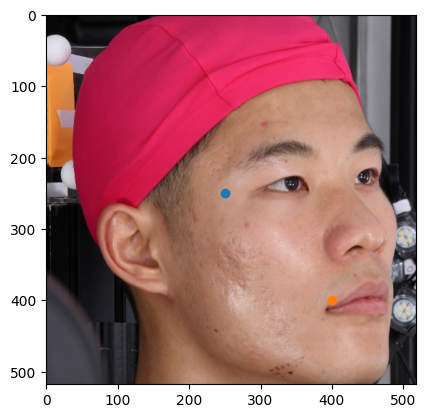

In [10]:
plt.imshow(images[0, 0].cpu().numpy().transpose(1, 2, 0))
plt.scatter(250,250)
plt.scatter(400,400)

In [7]:
test_idx = load_indices[0]

In [49]:
load_indices

(4, 5, 9, 10, 13, 15, 18, 21, 24, 26, 30, 39, 44, 46, 47, 48)

[[ 0.29843466  0.51841847 -0.80136075  2.07750502]
 [-0.90977173 -0.09931068 -0.40305431  1.06987577]
 [-0.28853448  0.84934073  0.44200472  0.66878767]
 [ 0.          0.          0.          1.        ]]


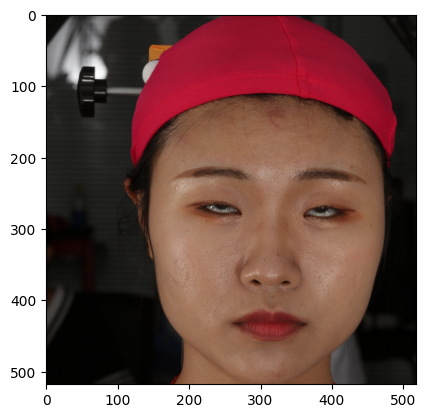

In [23]:
print(all_extrinsics[0])
plt.imshow(all_images[0])

In [60]:
f1 = []
f2 = []
c1 = []
c2 = []
fmaps = []

for epoch in trange(500):
    select_indices = random.sample(load_indices, 16)
    idx_test_index = select_indices.index(test_idx)
    if select_indices[0] != 9:
        continue
    images_select = load_data(select_indices)[0]
    images_select = torch.from_numpy(images_select).to(device).float()
    images_select = images_select.permute(0, 3, 1, 2)  # 16, 518, 518, 3 -> 16, 3, 518, 518
    images_select = images_select[None]  # add batch dimension
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            aggregated_tokens_list, ps_idx = model.aggregator(images_select)
        feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images_select, ps_idx)[0]
        feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
        feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
        feature_maps_ = feature_maps
    f1.append(feature_maps_[idx_test_index, 250, 250].cpu().numpy())
    f2.append(feature_maps_[idx_test_index, 400, 400].cpu().numpy())
    c1.append(images_select[0, idx_test_index, :, 250, 250].cpu().numpy())
    c2.append(images_select[0, idx_test_index, :, 400, 400].cpu().numpy())
    fmaps.append(feature_maps_[idx_test_index].cpu().numpy())

f1 = np.array(f1)
f2 = np.array(f2)
c1 = np.array(c1)
c2 = np.array(c2)
fmaps = np.array(fmaps)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_94194/3865816401.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
100%|██████████| 500/500 [00:56<00:00,  8.92it/s]


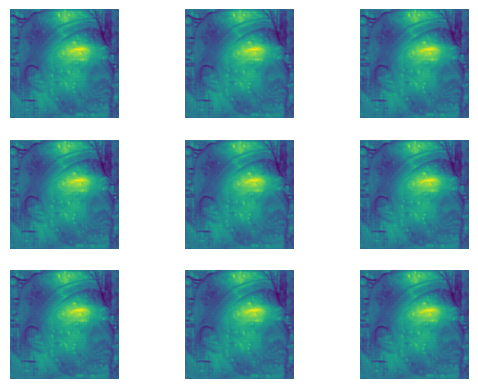

In [61]:
# make a 3*3 subplot using fmaps[i,:,:,0] as the image
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fmaps[i,:,:,0])
    plt.axis('off')

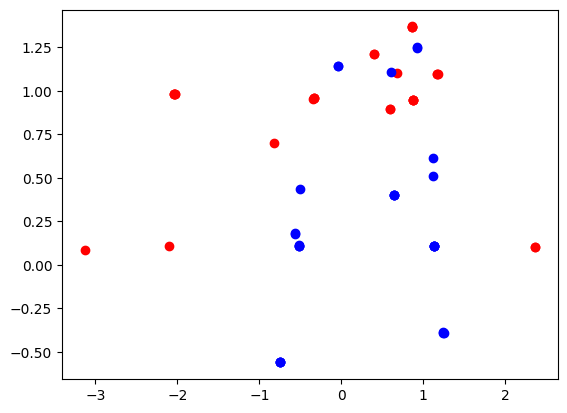

In [74]:
vis_idxs = random.sample(range(128),2)
v1, v2  = vis_idxs[0], vis_idxs[1]

plt.scatter(fmaps[:, 250, 250, v1], fmaps[:, 250, 250, v2], c='r')
plt.scatter(fmaps[:, 400, 400, v1], fmaps[:, 400, 400, v2], c='b')

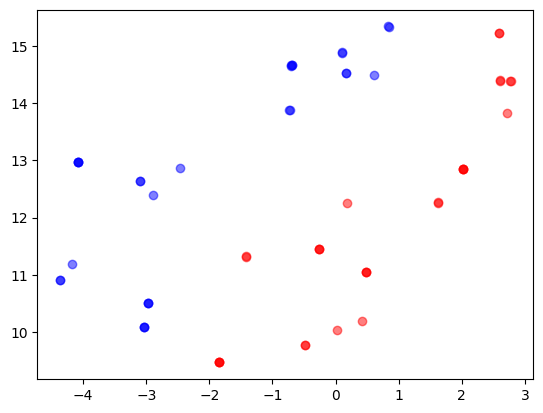

In [90]:
# using tsne to visualize the features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X = np.concatenate([f1, f2], axis=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:len(f1), 0], X_tsne[:len(f1), 1], c='r', label='250,250', alpha=0.5)
plt.scatter(X_tsne[len(f1):, 0], X_tsne[len(f1):, 1], c='b', label='400,400', alpha=0.5)

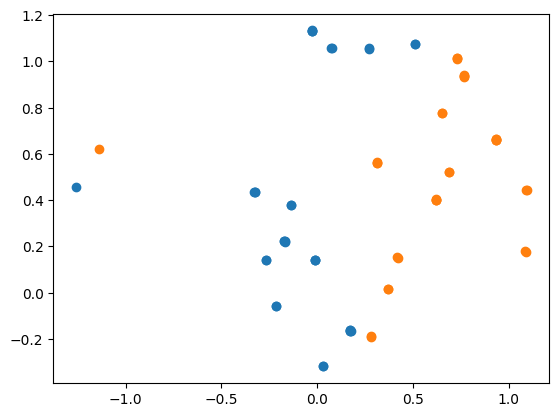

In [62]:
vis_idxs = random.sample(range(128),2)
v1, v2  = vis_idxs[0], vis_idxs[1]

plt.scatter(f1[:, v1], f1[:, v2], label='250,250')
plt.scatter(f2[:, v1], f2[:, v2], label='400,400')

select_indices = load_indices
images_select = load_data(select_indices)[0]
images_select = torch.from_numpy(images_select).to(device).float()
images_select = images_select.permute(0, 3, 1, 2)  # 16, 518, 518, 3 -> 16, 3, 518, 518
images_select = images_select[None]  # add batch dimension
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        aggregated_tokens_list, ps_idx = model.aggregator(images_select)
    feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images_select, ps_idx)[0]
    feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    feature_maps_ = feature_maps

In [274]:
agg1 = aggregated_tokens_list[-1][0]
agg1 = feature_maps_

In [275]:
# keep the first item of select_indices, random shuffle the rest
select_indices = [select_indices[0]] + random.sample(select_indices[1:], len(select_indices) - 1)
select_indices = list(load_indices)
select_indices[0],select_indices[1] = select_indices[1],select_indices[0]

images_select = load_data(select_indices)[0]
images_select = torch.from_numpy(images_select).to(device).float()
images_select = images_select.permute(0, 3, 1, 2)  # 16, 518, 518, 3 -> 16, 3, 518, 518
images_select = images_select[None]  # add batch dimension
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        aggregated_tokens_list, ps_idx = model.aggregator(images_select)
    feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images_select, ps_idx)[0]
    feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
    feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
    feature_maps_ = feature_maps

/tmp/ipykernel_68074/2781533023.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [276]:
agg2 = aggregated_tokens_list[-1][0]
agg2 = feature_maps_

In [277]:
agg2_rearrange = torch.zeros_like(agg2)
for i in range(16):
    chongpai_ind = select_indices[i]
    chongpai_ind = load_indices.index(chongpai_ind)
    print(chongpai_ind)
    agg2_rearrange[chongpai_ind] = agg2[i]

1
0
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [278]:
cal_dim = [1, 2, 3] if len(agg1.shape) == 4 else [1, 2]
loss_agg1_agg2_rearrange = (agg1 - agg2_rearrange).square().sum(dim=cal_dim)

<BarContainer object of 16 artists>

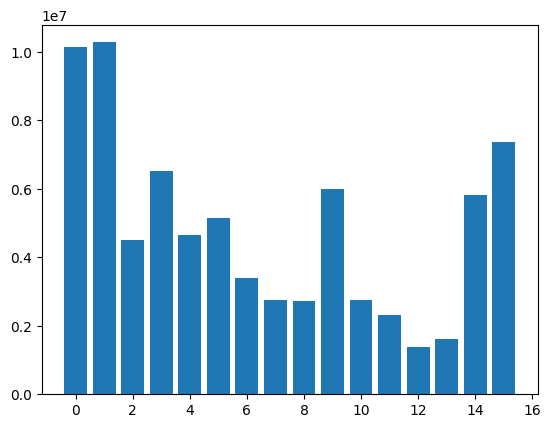

In [279]:
plt.bar(range(16), loss_agg1_agg2_rearrange.cpu().numpy())

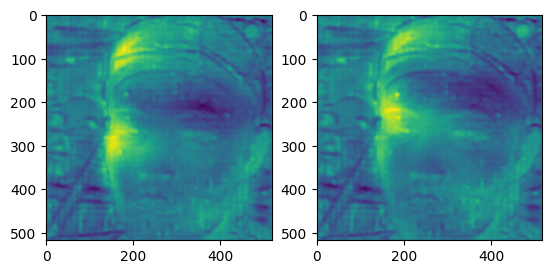

In [280]:
plt.subplot(1,2,1)
vis_ind = 5
plt.imshow(agg1[vis_ind,:,:,0].cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(agg2_rearrange[vis_ind,:,:,0].cpu().numpy())

#### 此处保证第一张图片是frontal ivew

In [7]:
idx = "2"
frontal_view_img_idx = 14

base_path = "/root/autodl-tmp/facescape"
img_path = os.path.join(base_path, "mv_image", idx)
depth_path = os.path.join(base_path, "depth", idx)
mask_path = os.path.join(base_path, "mask", idx)
params_path = os.path.join(base_path, "params", idx)

n_imgs = len(os.listdir(img_path))
def load_data(load_indices):
    depth_map = []
    extrinsic = []
    intrinsic = []
    images = []
    masks = []

    for load_index in load_indices:
        if False:
            img, depth, mask, extr, intr = data_cache[load_index]
        else:
            img = cv2.imread(os.path.join(img_path, f"{load_index}.png"))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (518, round(2592/1728*518)))
            # img = img[130:130+518, 0:518]
            depth = np.load(os.path.join(depth_path, f"{load_index}.npy"))
            # depth = cv2.resize(depth, (518, round(2592/1728*518)))
            # depth = depth[130:130+518, 0:518]
            mask = np.load(os.path.join(mask_path, f"{load_index}.npy"))
            # mask = cv2.resize(mask, (518, round(2592/1728*518)))
            # mask = mask[130:130+518, 0:518]
            params = np.load(os.path.join(params_path, f"{load_index}.npz"))
            extr = params["extr"]
            intr = params["intr"]
            # intr = intr * 518 / 1728
            # intr[1,2] = intr[1,2] - 130
            # data_cache[load_index] = (img, depth, mask, extr, intr)
        depth_map.append(depth)
        extrinsic.append(extr)
        intrinsic.append(intr)
        images.append(img)
        masks.append(mask)

    images = np.array(images)
    images = images / 255.
    masks = np.array(masks)
    depth_map = np.array(depth_map)
    extrinsic = np.array(extrinsic)
    intrinsic = np.array(intrinsic)
    return images, depth_map, extrinsic, intrinsic, masks

all_images, all_depth_maps, all_extrinsics, all_intrinsics, all_masks = load_data(list(range(n_imgs)))

def load_data(load_indices):
    load_indices = list(load_indices)
    images = all_images[load_indices]
    depth_maps = all_depth_maps[load_indices]
    extrinsics = all_extrinsics[load_indices]
    intrinsics = all_intrinsics[load_indices]
    masks = all_masks[load_indices]
    return images, depth_maps, extrinsics, intrinsics, masks

load_indices_samples = set()
while True:
    samples = list(range(n_imgs))
    random.shuffle(samples)
    samples = samples[:16]
    samples = sorted(samples)
    if frontal_view_img_idx in samples:
        # make sure the frontal view is the first image
        samples.remove(frontal_view_img_idx)
        samples.insert(0, frontal_view_img_idx)
    else:
        continue
    load_indices_samples.add(tuple(samples))
    if len(load_indices_samples) == 1000:
        break
load_indices_samples = list(load_indices_samples)
train_indices = load_indices_samples[:800]
val_indices = load_indices_samples[800:900]
test_indices = load_indices_samples[900:]

In [34]:
vis_view = 8

In [35]:
fmaps = []
load_indices_records = []
cs = []

for i in trange(100):
    load_indices = train_indices[i]
    if vis_view not in load_indices:
        continue
    view_view_ind_in_load_indices = load_indices.index(vis_view)
    images_select = load_data(load_indices)[0]
    images_select = torch.from_numpy(images_select).to(device).float()
    images_select = images_select.permute(0, 3, 1, 2)  # 16, 518, 518, 3 -> 16, 3, 518, 518
    images_select = images_select[None]  # add batch dimension
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            aggregated_tokens_list, ps_idx = model.aggregator(images_select)
        feature_maps = model.track_head.feature_extractor(aggregated_tokens_list, images_select, ps_idx)[0]
        feature_maps = torch.nn.functional.interpolate(feature_maps, size=(518, 518), mode='bilinear', align_corners=False)
        feature_maps = feature_maps.permute(0, 2, 3, 1) # 16, 518, 518, 128
        feature_maps_ = feature_maps
    fmaps.append(feature_maps_[view_view_ind_in_load_indices].cpu().numpy())
    cs.append(images_select[0, view_view_ind_in_load_indices,...].cpu().numpy())
    load_indices_records.append(load_indices)
fmaps = np.array(fmaps)
cs = np.array(cs)
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_104709/3025597278.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


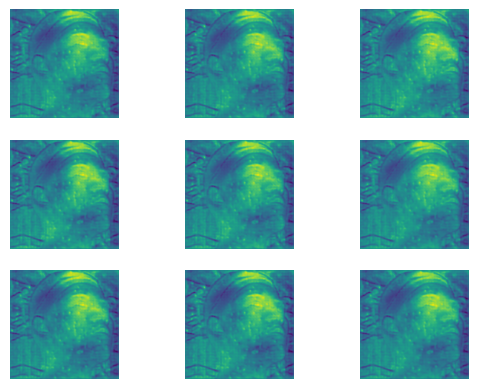

In [36]:
# make a 3*3 subplot using fmaps[i,:,:,0] as the image
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fmaps[i,:,:,0])
    plt.axis('off')

查看features是否有一定的内聚性

In [3]:
nose_ind = 4706
mouth_ind = 5008

In [8]:
nose_features = np.zeros((30, 128), dtype=np.float32)
mouth_features = np.zeros((30, 128), dtype=np.float32)

from sklearn.neighbors import NearestNeighbors

for i in trange(1,31):
    all_points = np.load(f"/root/autodl-tmp/facescape/all_features/{i}/all_points.npy")
    all_features = np.load(f"/root/autodl-tmp/facescape/all_features_ln/{i}/all_features.npy")

    target_mesh = o3d.io.read_triangle_mesh(f"/root/autodl-tmp/facescape/mesh/{i}_ictcut.ply")
    vertices = np.asarray(target_mesh.vertices)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(all_points)
    query_points = vertices[[nose_ind, mouth_ind]]
    distances, indices = nbrs.kneighbors(query_points)
    nose_features[i-1] = all_features[indices[0][0]]
    mouth_features[i-1] = all_features[indices[1][0]]
    del all_points, all_features

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [04:31<00:00,  9.06s/it]


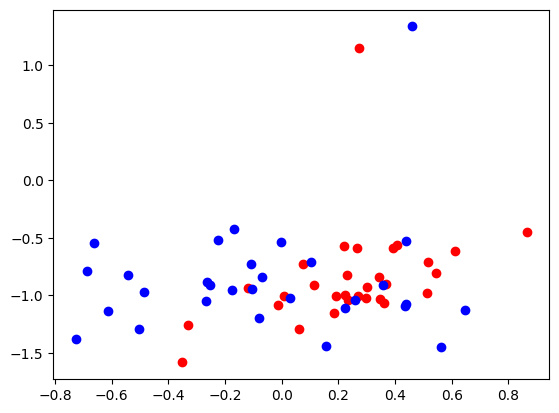

In [30]:
vis_inds = random.sample(range(128), 2)
v1, v2 = vis_inds[0], vis_inds[1]

plt.scatter(nose_features[:, v1], nose_features[:, v2], c='r', label='nose')
plt.scatter(mouth_features[:, v1], mouth_features[:, v2], c='b', label='mouth')

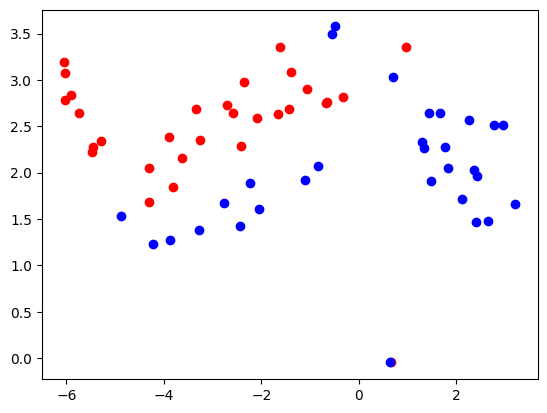

In [10]:
# using tsne to visualize the features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X = np.concatenate([nose_features, mouth_features], axis=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:30, 0], X_tsne[:30, 1], c='r', label='nose')
plt.scatter(X_tsne[30:, 0], X_tsne[30:, 1], c='b', label='mouth')

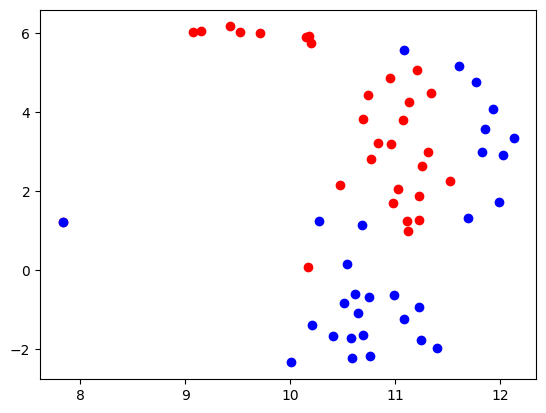

In [58]:
# using tsne to visualize the features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X = np.concatenate([nose_features, mouth_features], axis=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:30, 0], X_tsne[:30, 1], c='r', label='nose')
plt.scatter(X_tsne[30:, 0], X_tsne[30:, 1], c='b', label='mouth')

In [17]:
i = 2

all_points = np.load(f"/root/autodl-tmp/facescape/all_features/{i}/all_points.npy")
all_features = np.load(f"/root/autodl-tmp/facescape/all_features/{i}/all_features.npy")

In [18]:
sample_indices = random.sample(range(len(all_points)), 10000)
all_points = all_points[sample_indices]
all_features = all_features[sample_indices]

In [19]:
# use tsne to decrease the dimension of all_features to 3
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, perplexity=30)
X_tsne = tsne.fit_transform(all_features)

In [20]:
# normalize X_tsne to [0, 1]
X_tsne_min = X_tsne.min(axis=0)
X_tsne_max = X_tsne.max(axis=0)
X_tsne = (X_tsne - X_tsne_min) / (X_tsne_max - X_tsne_min)

In [21]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(all_points)
pcd.colors = o3d.utility.Vector3dVector(X_tsne[:, :3])  # use the first three dimensions for color

o3d.io.write_point_cloud(f"/root/autodl-tmp/facescape/vis_features.ply", pcd)

True

In [58]:
from sklearn.neighbors import NearestNeighbors
i = 2
all_points = np.load(f"/root/autodl-tmp/facescape/all_features/{i}/all_points.npy")
all_features = np.load(f"/root/autodl-tmp/facescape/all_features/{i}/all_features.npy")
target_mesh = o3d.io.read_triangle_mesh(f"/root/autodl-tmp/facescape/mesh/{i}_ictcut.ply")
vertices = np.asarray(target_mesh.vertices)
nbrs = NearestNeighbors(n_neighbors=30, algorithm='auto').fit(all_points)
query_points = vertices[[nose_ind, mouth_ind]]
distances, indices = nbrs.kneighbors(query_points)

In [59]:
nose_features = all_features[indices[0]]
mouth_features = all_features[indices[1]]

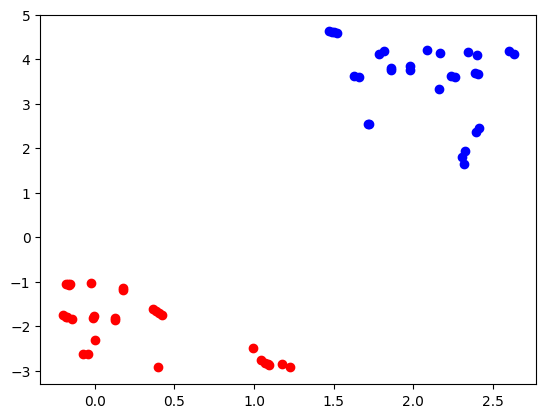

In [57]:
# no frontal view
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X = np.concatenate([nose_features, mouth_features], axis=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:30, 0], X_tsne[:30, 1], c='r', label='nose')
plt.scatter(X_tsne[30:, 0], X_tsne[30:, 1], c='b', label='mouth')

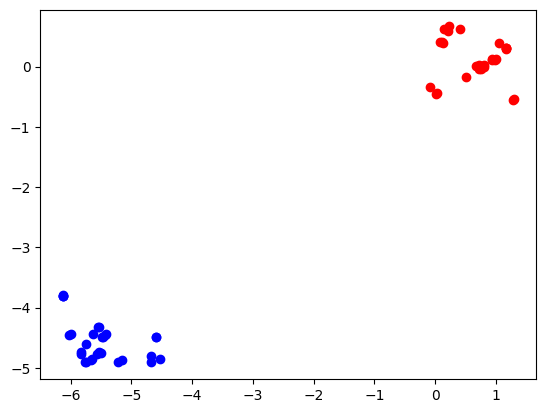

In [60]:
# frontal view
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
X = np.concatenate([nose_features, mouth_features], axis=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:30, 0], X_tsne[:30, 1], c='r', label='nose')
plt.scatter(X_tsne[30:, 0], X_tsne[30:, 1], c='b', label='mouth')